Данные это браузерная история пользователей – тайтлы и урлы страниц которые посещал пользователь. Нужно научится предсказывать возраст пользователя.




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import manifold, decomposition, linear_model, ensemble, neighbors, cross_validation


import seaborn as sns
import xgboost
import re
import nltk
import pymorphy2
import enchant

from heamy.dataset import Dataset
from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline

/Users/Roman/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


$\textbf{метрика RMSE}$

In [2]:
def rmse(x,y):
    return np.mean((x - y) ** 2) ** 0.5

загрузка данных url_domain_train

In [3]:
urls_train_df = pd.read_csv('data/url_domain_train.csv', header=None, delimiter='\t')

In [4]:
urls_train_df.columns = ['id', 'url', 'count']
urls_train_df.head()

,id,url,count
0,000000014B60815F65B38258011B6C01,login.rutracker.org,1
1,000000014B60815F65B38258011B6C01,rutracker.org,4
2,000000014C03DA2A47AC433A0C755201,admin.tour-spb.net,1
3,000000014C03DA2A47AC433A0C755201,czinfo.ru,1
4,000000014C03DA2A47AC433A0C755201,forumsostav.ru,1


нужно учесть count: разобьем url'ы на части: login.rutracker.org $\to$ 'login rutracker org'

In [5]:
sep_tmp = urls_train_df
sep_tmp['url'] = sep_tmp['url'].astype('str')
sep_tmp['space'] = ' '
sep_tmp['array_of_url'] = (sep_tmp['url'] + sep_tmp['space']).apply(lambda x: re.findall(r"[\w']+",x)) * sep_tmp['count']
sep_tmp.drop(['space'], axis = 1, inplace=True)
sep_tmp.head()

,id,url,count,array_of_url
0,000000014B60815F65B38258011B6C01,login.rutracker.org,1,"[login, rutracker, org]"
1,000000014B60815F65B38258011B6C01,rutracker.org,4,"[rutracker, org, rutracker, org, rutracker, or..."
2,000000014C03DA2A47AC433A0C755201,admin.tour-spb.net,1,"[admin, tour, spb, net]"
3,000000014C03DA2A47AC433A0C755201,czinfo.ru,1,"[czinfo, ru]"
4,000000014C03DA2A47AC433A0C755201,forumsostav.ru,1,"[forumsostav, ru]"


In [6]:
sep_URLS = pd.DataFrame(sep_tmp.groupby('id').array_of_url.apply(lambda x: x.tolist()))
sep_URLS.head()

,array_of_url
id,
000000013CB5719C0000A2C90002C101,"[[id, rambler, ru], [mail, rambler, ru], [r0, ..."
00000001442BE24000001B7D00F50801,"[[1prime, ru], [autorambler, ru], [chellak, ru..."
00000001448580F800003F1B31FB0901,"[[bosch, korolev, ru]]"
0000000145BDB2FF000157971645E901,"[[aptekanizkihcen, ua], [colady, ru], [gorod, ..."
000000014602771F0000DB9359714C01,"[[astrorok, ru], [diets, ru], [edaplus, info],..."


In [7]:
def sep_f(x):
    a = []
    for i in range(len(x)):
        for j in range(len(x[i])):
            a.append(x[i][j])
    return " ".join(a)

In [8]:
sep_URLS['list'] = sep_URLS.array_of_url.apply(sep_f)
sep_URLS.drop(['array_of_url'], axis = 1, inplace=True)
sep_URLS['id'] = sep_URLS.index
sep_URLS.index = range(len(sep_URLS))
sep_URLS.columns = ['urls', 'id']

In [10]:
age_train_df = pd.read_csv('data/age_profile_train.csv', header=None, delimiter='\t')
age_train_df.columns = ['id', 'age']
age_train_df.head()

,id,age
0,000000013CB5719C0000A2C90002C101,53
1,00000001442BE24000001B7D00F50801,48
2,00000001448580F800003F1B31FB0901,28
3,0000000145BDB2FF000157971645E901,44
4,000000014602771F0000DB9359714C01,48


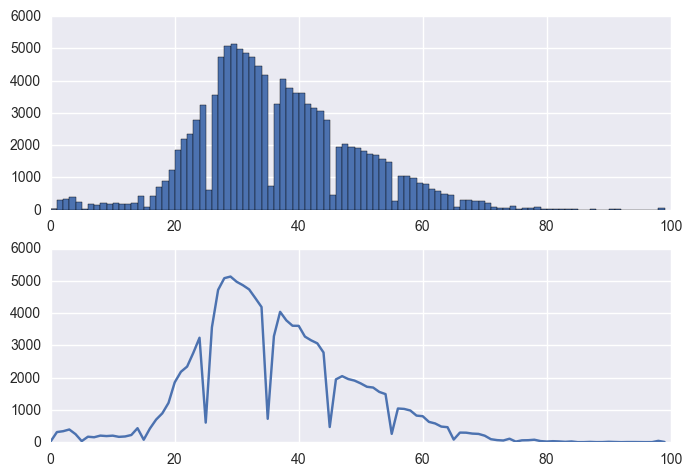

In [12]:
plt.subplot(2, 1, 1)
plt.hist(age_train_df.age, bins=99)

plt.subplot(2, 1, 2)
plt.plot(age_train_df.groupby('age')['id'].count())

In [13]:
sep_train_df = sep_URLS.merge(age_train_df, on = 'id', how='left')
sep_train_df.head()

,urls,id,age
0,id rambler ru mail rambler ru r0 ru,000000013CB5719C0000A2C90002C101,53
1,1prime ru autorambler ru chellak ru docs cntd ...,00000001442BE24000001B7D00F50801,48
2,bosch korolev ru,00000001448580F800003F1B31FB0901,28
3,aptekanizkihcen ua colady ru gorod dp ua i ovk...,0000000145BDB2FF000157971645E901,44
4,astrorok ru diets ru edaplus info eshzdorovo r...,000000014602771F0000DB9359714C01,48


#### стемминг слов

In [14]:
stemmer = nltk.stem.PorterStemmer()

In [15]:
def stemming(x):
    ret_array = []
    array = x.split(" ")
    for word in array:
        ret_array.append(stemmer.stem(word))
    return " ".join(ret_array)

In [16]:
stem_train_df = sep_train_df.copy()
stem_train_df.urls = stem_train_df.urls.apply(lambda x: stemming(x))
sep_X = sep_train_df.urls
y_urls = sep_train_df.age
train = sep_train_df[['urls']]

CV и стэккинг 

In [17]:
train_data, test_data, y_train, y_test = cross_validation.train_test_split(train, y_urls, test_size = 0.33)
y_urls.values

array([53, 48, 28, ..., 56, 31, 35])

In [18]:
def lr_tfidf_fit_predict(X_train, y_train, X_test):
    model = linear_model.SGDRegressor(alpha = 0.00005, n_iter=200)
    model.fit(X_train, y_train)
    print "lr_tfidf fitted"
    return model.predict(X_test)

def rf_tfidf_fit_predict(X_train, y_train, X_test):
    model = ensemble.RandomForestRegressor(n_estimators=160, max_depth=20, n_jobs=-1)
    model.fit(X_train, y_train)
    print "rf_tfidf fitted"
    return model.predict(X_test)

def xgb(X_train, y_train, X_test):
    model = Pipeline([('svd', decomposition.TruncatedSVD(n_components=150)),
                            ('xgb', xgboost.XGBRegressor(max_depth=8, learning_rate=0.05, n_estimators=300))])
    model.fit(X_train, y_train)
    print "svd_lr fitted"
    return model.predict(X_test)

def svd_50_rf(X_train, y_train, X_test):
    model = Pipeline([('svd', decomposition.TruncatedSVD(n_components = 50)),
                            ('rf', ensemble.RandomForestRegressor(n_estimators=150, max_depth=20, n_jobs=-1))])
    model.fit(X_train, y_train)
    print "svd_50_rf fitted"
    return model.predict(X_test)


def svd_200_rf(X_train, y_train, X_test):
    model = Pipeline([('svd', decomposition.TruncatedSVD(n_components=100)),
                            ('rf', ensemble.RandomForestRegressor(n_estimators=100, max_depth=20, n_jobs=-1))])
    model.fit(X_train, y_train)
    print "svd_200_rf fitted"
    return model.predict(X_test)

models = [lr_tfidf_fit_predict, rf_tfidf_fit_predict, xgb, svd_50_rf, svd_200_rf]

In [ ]:
tfidf = TfidfVectorizer(analyzer = u'char', ngram_range=(1,3))
train = tfidf.fit_transform(train_data.urls)
test = tfidf.transform(test_data.urls)

for estimator in models:
    print rmse(y_test, estimator(train, y_train, test))

#### Теперь загрузим title_unify_train

In [19]:
title_train = pd.read_csv('data/title_unify_train.csv', header=None, sep='\t')
title_train.head()

,0,1,2
0,000000014B6D41C13D777E8314725401,коляна лента прикол,1
1,0000000150707ACB8A82451C0307BC01,candi410 rambler ru входящая рамблер-почта,1
2,0000000150707ACB8A82451C0307BC01,cosmopolitan витамин волос для женщина журнал ...,1
3,0000000150707ACB8A82451C0307BC01,realbox бокс для интернет-магазин страница тов...,1
4,0000000150707ACB8A82451C0307BC01,realbox бокс для интернет-магазин товар экипир...,2


In [20]:
title_train.columns = ['id', 'unify', 'count']

In [21]:
tmp = title_train
tmp['unify'] = tmp['unify'].astype('str')
tmp['space'] = ' '
tmp['array_of_unify'] = (tmp['unify'] + tmp['space']).apply(lambda x: x.split(' ')[:-1]) * tmp['count']
tmp.drop(['space'], axis = 1, inplace=True)
tmp.head()

,id,unify,count,array_of_unify
0,000000014B6D41C13D777E8314725401,коляна лента прикол,1,"[коляна, лента, прикол]"
1,0000000150707ACB8A82451C0307BC01,candi410 rambler ru входящая рамблер-почта,1,"[candi410, rambler, ru, входящая, рамблер-почта]"
2,0000000150707ACB8A82451C0307BC01,cosmopolitan витамин волос для женщина журнал ...,1,"[cosmopolitan, витамин, волос, для, женщина, ж..."
3,0000000150707ACB8A82451C0307BC01,realbox бокс для интернет-магазин страница тов...,1,"[realbox, бокс, для, интернет-магазин, страниц..."
4,0000000150707ACB8A82451C0307BC01,realbox бокс для интернет-магазин товар экипир...,2,"[realbox, бокс, для, интернет-магазин, товар, ..."


In [23]:
UNIFY = pd.DataFrame(tmp.groupby('id').array_of_unify.apply(lambda x: x.tolist()))
UNIFY['list'] = UNIFY.array_of_unify.apply(sep_f)
UNIFY.drop(['array_of_unify'], axis = 1, inplace=True)

In [24]:
UNIFY['id'] = UNIFY.index
UNIFY.index = range(len(UNIFY))
UNIFY.columns = ['unify', 'id']
UNIFY.head()

,unify,id
0,бесплатный надёжный почта рамблер электронный ...,000000013CB5719C0000A2C90002C101
1,24-х 34-х до договор неделя новость предложить...,00000001442BE24000001B7D00F50801
2,авто бош контакт королёв сервис авто бош корол...,00000001448580F800003F1B31FB0901
3,ua втрать війни донбасі за на новини озвучить ...,0000000145BDB2FF000157971645E901
4,black walnut грецкий орех чёрный inmoment ru w...,000000014602771F0000DB9359714C01


In [25]:
train_un = UNIFY.merge(age_train_df, on='id', how='left')
train_un.head()

,unify,id,age
0,бесплатный надёжный почта рамблер электронный ...,000000013CB5719C0000A2C90002C101,53
1,24-х 34-х до договор неделя новость предложить...,00000001442BE24000001B7D00F50801,48
2,авто бош контакт королёв сервис авто бош корол...,00000001448580F800003F1B31FB0901,28
3,ua втрать війни донбасі за на новини озвучить ...,0000000145BDB2FF000157971645E901,44
4,black walnut грецкий орех чёрный inmoment ru w...,000000014602771F0000DB9359714C01,48


In [29]:
morph = pymorphy2.MorphAnalyzer()

In [30]:
def norm_form(x):
    tmp = " ".join(x)
    string = unicode(tmp,'utf-8','ignore')
    p = morph.parse(string)[0]
    return p.normal_form

In [ ]:
train_morph = train_un.copy()
train_morph.unify = train_morph.unify.apply(lambda x: norm_form(x))

tfidf = sklearn.feature_extraction.text.TfidfVectorizer()
morph_X = tfidf.fit_transform(train_morph.unify)

In [ ]:
morph_y = train_morph.age

In [ ]:
score = []

for k in range(5):
    mean = []
    for i in range(5):
        train_data, test_data, y_train, y_test = cross_validation.train_test_split(morph_X, y,\
                                                                                    test_size = 0.3)
        
        lin_reg = linear_model.SGDRegressor(n_iter=550, alpha=0.00003)
        lin_reg.fit(train_data, y_train)
        print rmse(lin_reg.predict(test_data), y_test)
        mean.append(rmse(lin_reg.predict(test_data), y_test))
        
    score.append(np.mean(mean))
print np.mean(score)